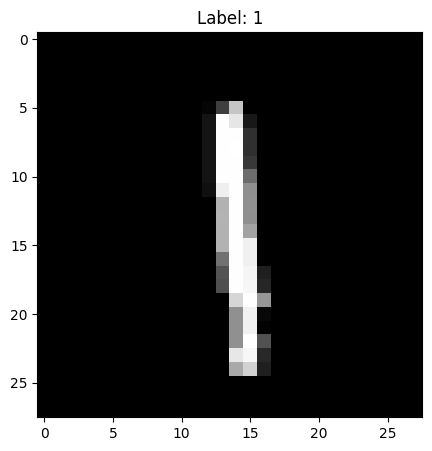

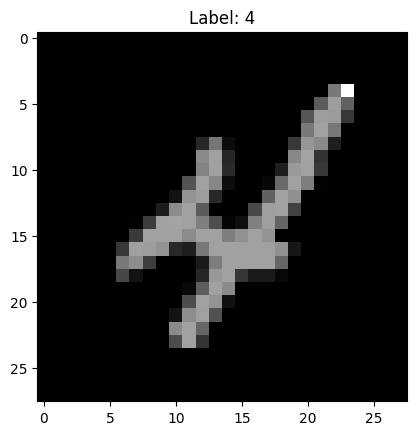

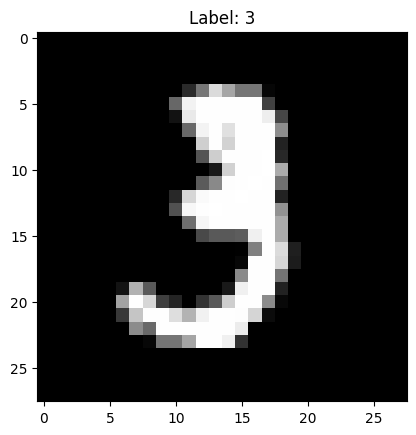

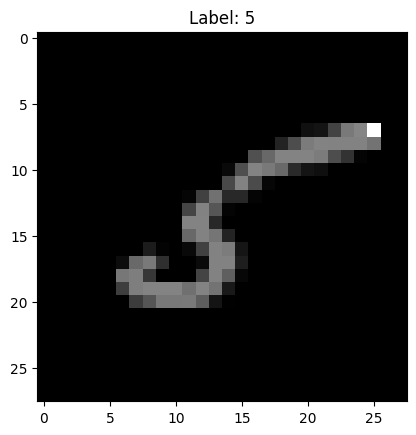

100%|██████████| 80/80 [00:03<00:00, 24.34it/s]


Epoch :  32


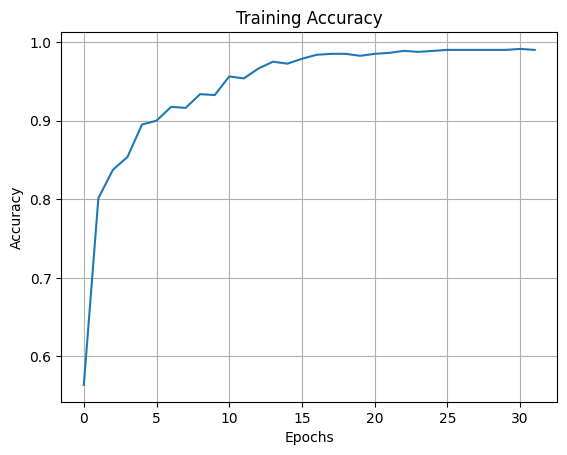

Training accuracy:  99.0 %


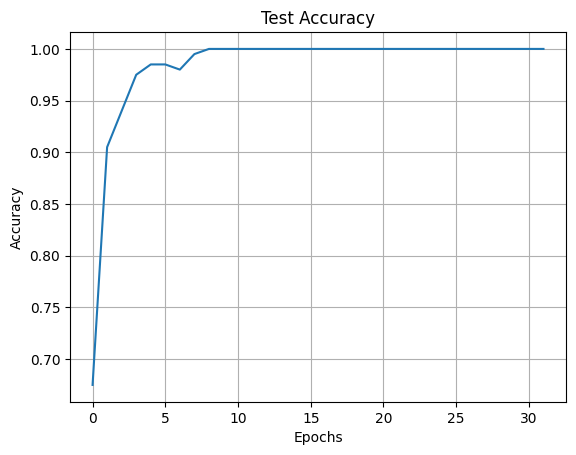

Training accuracy: 99.00%
Test accuracy: 100.00%
Training set loss last val: 2.25%
Test set loss last val: 0.47%
     Predicted  Actual
0            9       9
1            2       2
2            6       6
3            7       7
4            4       4
..         ...     ...
195          7       7
196          6       6
197          0       0
198          3       3
199          6       6

[200 rows x 2 columns]


In [ ]:
#Importing necessary libraries and modules for the implementation of the neural network.
from tqdm import trange
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

#This function is used to load the MNIST dataset from a .pkl file, normalize and scale the pixel values of the images, 
#and return the train and test sets with their corresponding labels.
def load_dataset(flatten=False):
    with open('/content/mnist_data.pkl', 'rb') as f:
        data = pickle.load(f)
    train_Images = pd.DataFrame(np.array(data['trainImages']))
    train_Labels = np.array(data['trainLabels'])
    test_Images = pd.DataFrame(np.array(data['testImages']))
    test_Labels = np.array(data['testLabels'])
    imagescale = MinMaxScaler()
    imagescale.fit(test_Images)
    train_Images = imagescale.transform(train_Images)
    test_Images = imagescale.transform(test_Images)
    return train_Images, train_Labels, test_Images, test_Labels

#These are classes for the different types of layers in the neural network, namely the base 
#Layer, ReLU_layer and Dense. The Layer class is an abstract class with two methods, 
#fwd() and bwd(), which will be overridden by the ReLU_layer and Dense subclasses. 
#The ReLU_layer class implements the ReLU activation function, and the Dense class is for fully 
#connected layers with methods to compute the forward and backward passes through the layer.
class Layer:
    def __init__(self):
        pass

    def fwd(self, input):
        return input

    def bwd(self, input, gradient_output):
        num_units = input.shape[1]
        input_lyrs = np.eye(num_units)
        return np.dot(gradient_output, input_lyrs)


class ReLU_layer(Layer):
    def __init__(self):
        super().__init__()

    def fwd(self, input):
        relu_fwd = np.maximum(0, input)
        return relu_fwd

    def bwd(self, input, gradient_output):
        relu_gradient = input > 0
        return gradient_output * relu_gradient


class Dense(Layer):
    def __init__(self, in_u, out_u, lr=0.01):
        super().__init__()
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(2 / (in_u + out_u)), size=(in_u, out_u))
        self.biases = np.zeros(out_u)
        self.lr = lr

    def fwd(self, input):
        return np.dot(input, self.weights) + self.biases

    def bwd(self, input, gradient_output):
        gradient_input = np.dot(gradient_output, self.weights.T)
        gradient_biases = gradient_output.mean(axis=0) * input.shape[0]
        gradient_weights = np.dot(input.T, gradient_output)
        self.biases = self.biases - self.lr * gradient_biases
        self.weights = self.weights - self.lr * gradient_weights
        return gradient_input

#This function implements forward propagation through a given neural network to produce the 
#output activations for a given input. It returns a list of activation values for each layer in the network.
def fwd(mlp_nwrk, x):
    act = []
    input = x
    for l in mlp_nwrk:
        act.append(l.fwd(input))
        input = act[-1]
    return act

#This function computes the forward pass of the neural network, computes the loss and 
#gradients, and performs backpropagation to update the weights. The updated loss is returned as a scalar.

def train(mlp_nwrk, x, y):
    layer_act = fwd(mlp_nwrk, x)
    logits = layer_act[-1]
    layer_inputs = [x] + layer_act
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_gradient = gradient_softmax_crossentropy_with_logits(logits, y)
    for k in range(len(mlp_nwrk))[::-1]:
        layer = mlp_nwrk[k]
        loss_gradient = layer.bwd(layer_inputs[k], loss_gradient)
    return np.mean(loss)

#predicts the class labels of input data using the trained neural network.
def predict(mlp_nwrk, x):
    logits = fwd(mlp_nwrk, x)[-1]
    return logits.argmax(axis=-1)

#computes the cross-entropy loss between the predicted logits and true labels using the softmax activation function. 
#It returns the cross-entropy loss value.
def softmax_crossentropy_with_logits(logits, true_labels):
    logits_for_true_labels = logits[np.arange(len(logits)), true_labels]
    cross_entropy = - logits_for_true_labels + np.log(np.sum(np.exp(logits), axis=-1))
    return cross_entropy

#calculates the gradient of the softmax cross-entropy loss with respect to the logits.
#It takes in the logits and true labels, 
#and returns the gradient as an array of the same shape as the logits.
def gradient_softmax_crossentropy_with_logits(logits, true_labels):
    ones_for_true_labels = np.zeros_like(logits)
    ones_for_true_labels[np.arange(len(logits)), true_labels] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_true_labels + softmax) / logits.shape[0]

#function generates mini-batches of inputs and targets of a specified batch size. 
#If shuffle is True, it shuffles the data before generating the batches. 
#It uses the yield statement to create a generator function that returns one mini-batch at a time.
def shuffler(inputs, targets, size_batch, shuffle=False):
    if shuffle:
        ind = np.random.permutation(len(inputs))
    for j in trange(0, len(inputs) - size_batch + 1, size_batch):
        if shuffle:
            excerpt = ind[j:j + size_batch]
        else:
            excerpt = slice(j, j + size_batch)
        yield inputs[excerpt], targets[excerpt]


if __name__ == '__main__':
    # load MNIST dataset  
    x_train, y_train, x_test, y_test = load_dataset(flatten=True)
    
    # display some images from the dataset
    plt.figure(figsize=[5, 5])
    for i in range(4):
        plt.title("Label: %i" % y_train[i + 8])
        plt.plot(2, 2, i + 1)
        plt.imshow(x_train[i + 8].reshape([28, 28]), cmap='gray')
        plt.show()
    
    # define multi-layer perceptron network
    mlp_nwrk = [Dense(x_train.shape[1], 500), ReLU_layer(), Dense(500, 250), ReLU_layer(), Dense(250, 25),
                ReLU_layer(), Dense(25, 10)]

    # train the network for 32 epochs using shuffled batches
    train_resultlist, test_resultlist, trainset_loss, testset_loss = [], [], [], []

    for epoch in range(32):
        for x_batch, y_batch in shuffler(x_train, y_train, size_batch=10, shuffle=True):
            temp_val_train = train(mlp_nwrk, x_batch, y_batch)
            temp_val_test = train(mlp_nwrk, x_test, y_test)
        trainset_loss.append(temp_val_train)
        testset_loss.append(temp_val_test)
        train_resultlist.append(np.mean(predict(mlp_nwrk, x_train) == y_train))
        test_resultlist.append(np.mean(predict(mlp_nwrk, x_test) == y_test))

    # Display training accuracy graph
    print("Epoch : ", len(train_resultlist))
    train_acc = train_resultlist[-1]
    plt.title("Training Accuracy")
    plt.plot(train_resultlist)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()
    print('Training accuracy: ', (100 * train_acc), '%')

    # Display test accuracy graph
    test_acc = np.mean(predict(mlp_nwrk, x_test) == y_test)
    plt.title("Test Accuracy")
    plt.plot(test_resultlist)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

   # Print training and test accuracy percentages
    print(f'Training accuracy: {train_acc:.2%}')
    print(f'Test accuracy: {test_acc:.2%}')

    # Print last values of training and test set losses
    print(f"Training set loss last val: {trainset_loss[-1]*100:.2f}%")
    print(f"Test set loss last val: {testset_loss[-1]*100:.2f}%")

    # Print dataframe showing predicted and actual labels of test data
    results = predict(mlp_nwrk, x_test)
    print(pd.DataFrame({'Predicted': results, 'Actual': y_test}))

 
    
